<a href="https://colab.research.google.com/github/magiwanders/CMLS_HW1/blob/master/src/2_TrainingSVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Urban sound dataset classification with SVM

## Import libraries

In [1]:
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
import sklearn.svm
import IPython.display as ipd
import scipy as sp
from pathlib import Path
import pandas as pd
import re
import json
from sklearn.svm import NuSVC
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

## Load the dataset features and check the data

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/CMLS_HW1_UrbanClassification/dataset"
%ls

Mounted at /content/drive
/content/drive/MyDrive/CMLS_HW1_UrbanClassification/dataset
extracted_features.json  fold3/  fold7/                prova_feature_2.json
fold1/                   fold4/  fold8/                UrbanSound8K.csv
fold10/                  fold5/  fold9/
fold2/                   fold6/  prova_feature_1.json


In [3]:
# Check if the shape of the data is correct
mfcc_pd = pd.read_json(r'extracted_features.json', orient='index')
mfcc_pd.head()

,features,shape,label_id,label,fold
0,"[[16.4946708679, -16.8162689209, 10.9875793457...","[1, 125]",4,drilling,1
1,"[[19.0360469818, -12.7741031647, 10.8814258575...","[1, 125]",0,air_conditioner,1
2,"[[17.4096260071, -13.1849765778, 10.8189029694...","[1, 125]",0,air_conditioner,1
3,"[[17.1266403198, -16.0122146606, 10.2732362747...","[1, 125]",2,children_playing,1
4,"[[14.6829175949, -17.8468894958, 10.2156419754...","[1, 125]",3,dog_bark,1


In [4]:
# Check the correspondence between label_id and labels
labels = set(mfcc_pd['label_id'])
mapping = []
for label_id in labels:
    
    label_name = set(mfcc_pd.loc[mfcc_pd['label_id'] == label_id]['label'])
    mapping.append((label_id,label_name))
label_mapping = dict(mapping)
label_mapping

{0: {'air_conditioner'},
 1: {'car_horn'},
 2: {'children_playing'},
 3: {'dog_bark'},
 4: {'drilling'},
 5: {'engine_idling'},
 6: {'gun_shot'},
 7: {'jackhammer'},
 8: {'siren'},
 9: {'street_music'}}

In [5]:
# Check how many audio samples for each label
labels = set(mfcc_pd['label'])
print(labels)
cnt = [[label,list(mfcc_pd['label']).count(label)] for label in labels]
dict_cnt = dict(cnt)
dict_cnt

{'siren', 'engine_idling', 'car_horn', 'drilling', 'gun_shot', 'air_conditioner', 'dog_bark', 'street_music', 'children_playing', 'jackhammer'}


{'air_conditioner': 1000,
 'car_horn': 429,
 'children_playing': 1000,
 'dog_bark': 1000,
 'drilling': 1000,
 'engine_idling': 1000,
 'gun_shot': 374,
 'jackhammer': 1000,
 'siren': 929,
 'street_music': 1000}

In [6]:
# Make the feature vector contiguous
ll = [np.asarray(mfcc_pd['features'][i]).ravel() for i in range(mfcc_pd.shape[0])]
mfcc_pd['sample'] = pd.Series(ll, index=mfcc_pd.index)
del mfcc_pd['features']

## Train and validate the SVM models

In [14]:
train_data = []
train_label = []
validation_data = []
validation_label = []
svm_accuracies = []
svm_models = []
svm_predictions = []

num_folds = 10

# Create the training and validation data
for i in range(1, num_folds+1):
  train_data.append(np.array(list(mfcc_pd.loc[mfcc_pd['fold'] != i]['sample'])))
  train_label.append(np.array(mfcc_pd.loc[mfcc_pd['fold'] != i]['label_id']))
  validation_data.append(np.array(list(mfcc_pd.loc[mfcc_pd['fold'] == i]['sample'])))
  validation_label.append(np.array(mfcc_pd.loc[mfcc_pd['fold'] == i]['label_id']))

# Train and validate a model for each k-fold combination
for i in range(0,num_folds):  
  print("train_data[%i].shape: %s, train_label[%i].shape: %s" %(i, train_data[i].shape, i, train_label[i].shape))
  svm = OneVsRestClassifier(NuSVC(nu=.05, kernel='poly', decision_function_shape='ovr'))
  svm_model = svm.fit(train_data[i], train_label[i])
  svm_models.append(svm_model)

  print("validation_data[%i].shape: %s, validation_label[%i].shape: %s" %(i, validation_data[i].shape, i, validation_label[i].shape))
  svm_prediction = svm_model.predict(validation_data[i])
  svm_predictions.append(svm_prediction)

  accuracy = np.sum(svm_prediction == validation_label[i])/validation_label[i].shape[0]
  print("accuracy of model n.%i: %f\n" %(i, accuracy))
  svm_accuracies.append(accuracy)

train_data[0].shape: (7859, 125), train_label[0].shape: (7859,)
validation_data[0].shape: (873, 125), validation_label[0].shape: (873,)
accuracy of model n.0: 0.578465

train_data[1].shape: (7844, 125), train_label[1].shape: (7844,)
validation_data[1].shape: (888, 125), validation_label[1].shape: (888,)
accuracy of model n.1: 0.351351

train_data[2].shape: (7807, 125), train_label[2].shape: (7807,)
validation_data[2].shape: (925, 125), validation_label[2].shape: (925,)
accuracy of model n.2: 0.449730

train_data[3].shape: (7742, 125), train_label[3].shape: (7742,)
validation_data[3].shape: (990, 125), validation_label[3].shape: (990,)
accuracy of model n.3: 0.502020

train_data[4].shape: (7796, 125), train_label[4].shape: (7796,)
validation_data[4].shape: (936, 125), validation_label[4].shape: (936,)
accuracy of model n.4: 0.518162

train_data[5].shape: (7909, 125), train_label[5].shape: (7909,)
validation_data[5].shape: (823, 125), validation_label[5].shape: (823,)
accuracy of model n

## Print the training statistics and the confusion matrices

In [15]:
def confusion(true, predicted):
  matrix = np.zeros([10,10])
  #d = 0
  for t, p in zip(true, predicted):
      matrix[t,p] += 1.5
  #    d += 1
  #print(d)
  return matrix

def plot_confusion_matrix(matrix, class_names, model_idx):
  plt.figure(figsize=[10,10])
  plt.imshow(matrix, cmap='hot', interpolation='nearest',  vmin=0, vmax=200)
  plt.colorbar()
  plt.title('SVM Confusion Map - model no. %i' %(model_idx), fontsize=18)
  plt.ylabel('Actual', fontsize=18)
  plt.xlabel('Predicted', fontsize=18)
  plt.grid(b=False)
  plt.yticks(range(10), class_names, fontsize=14)
  plt.xticks(range(10), class_names, fontsize=14, rotation='vertical')
  plt.show()

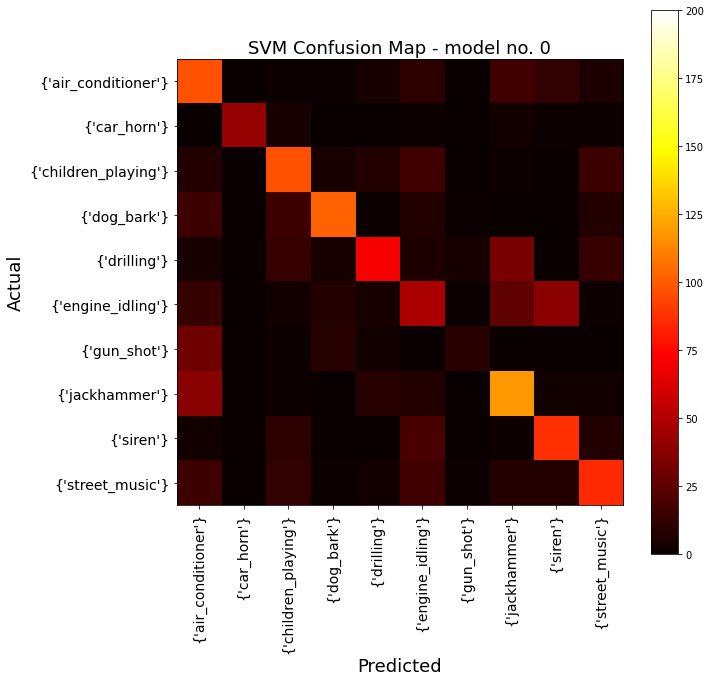

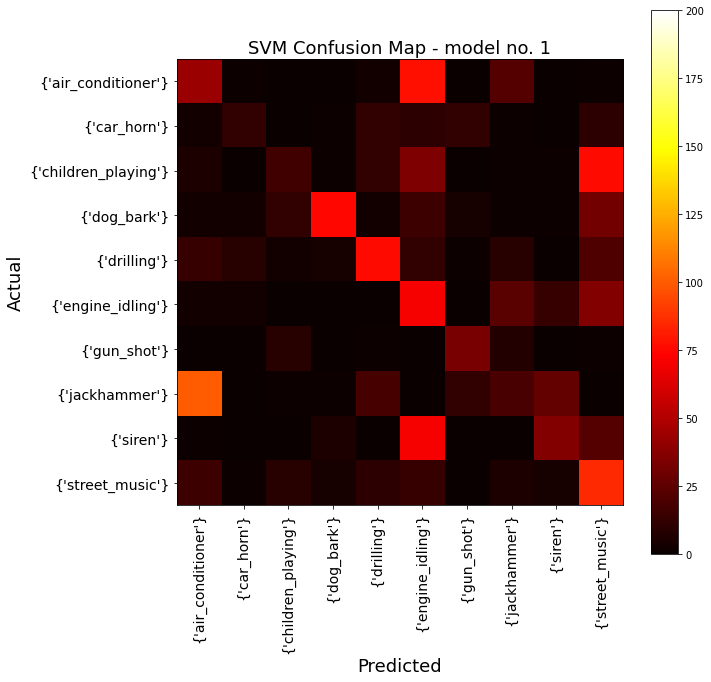

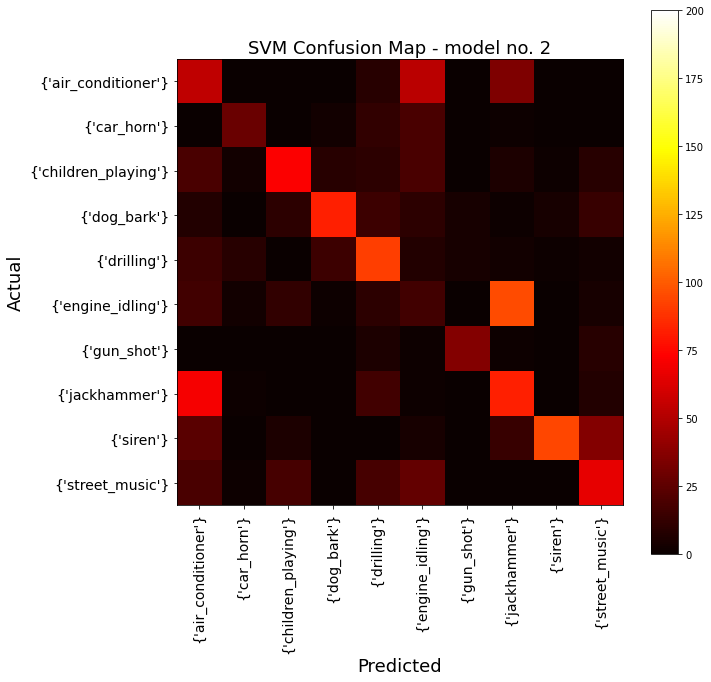

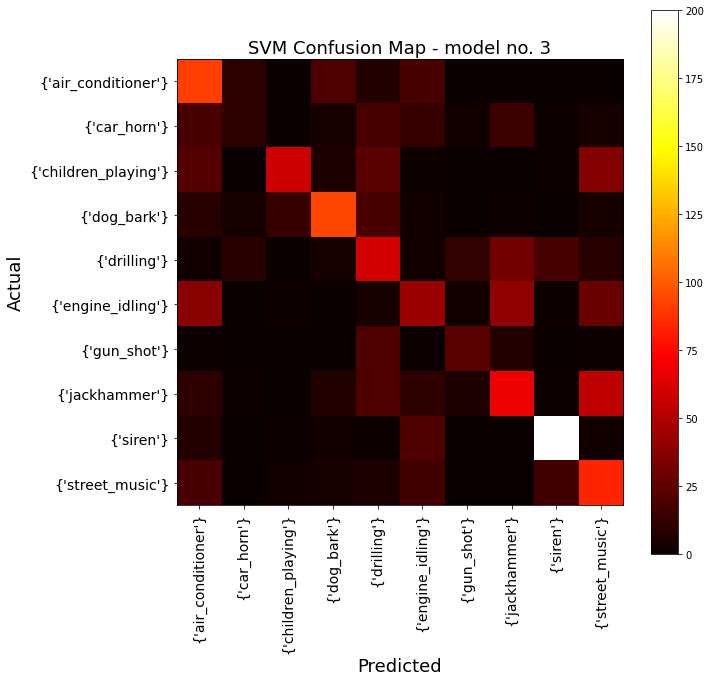

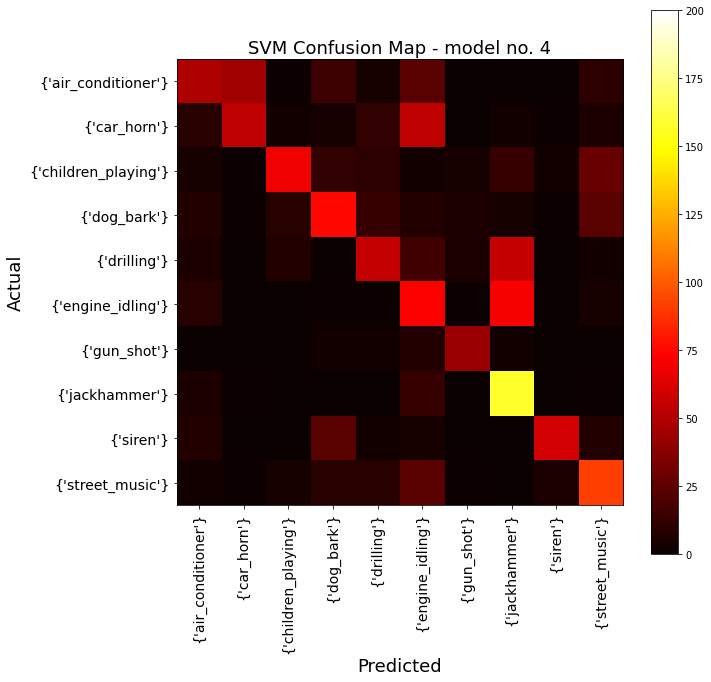

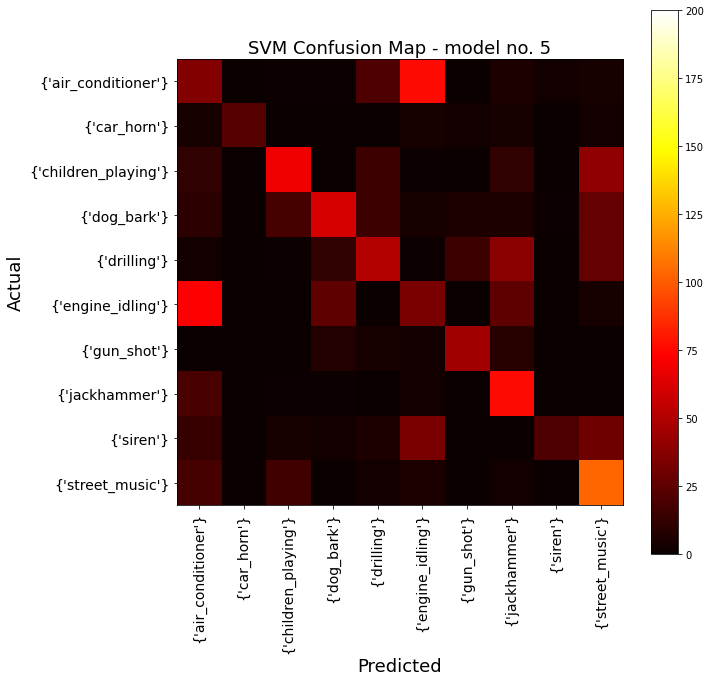

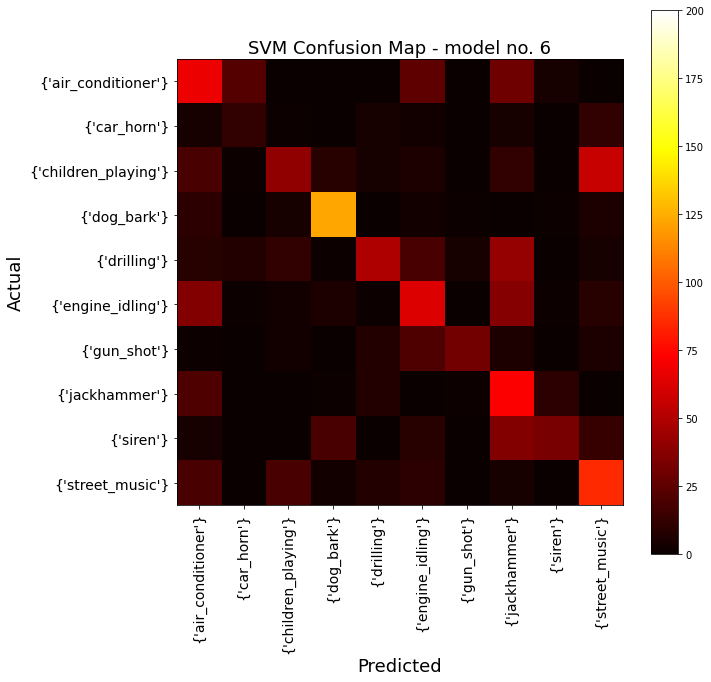

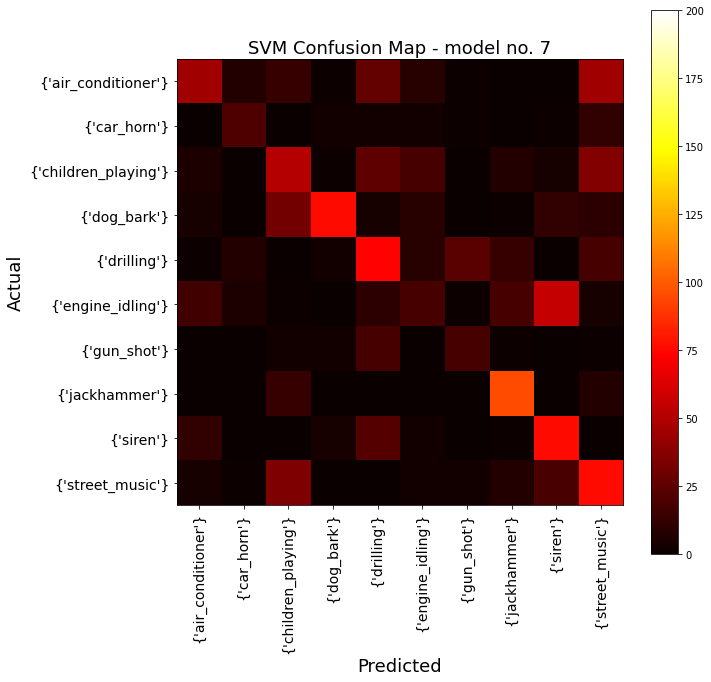

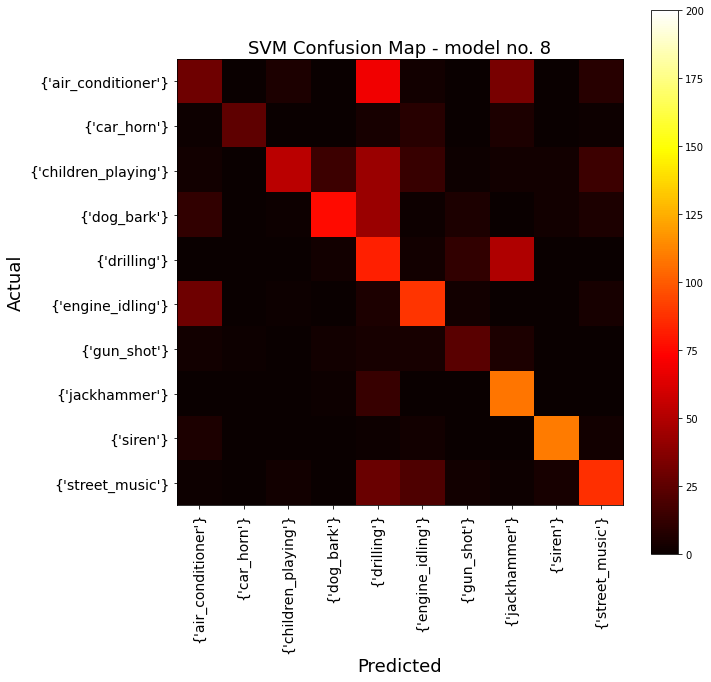

In [16]:
class_names = label_mapping.values()

for i in range(0, num_folds-1):
  matrix = confusion(validation_label[i], svm_predictions[i])
  plot_confusion_matrix(matrix, class_names, i)